# Project Data

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import keras.src.saving.saving_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score

You should consider upgrading via the 'C:\Users\bujowskis\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


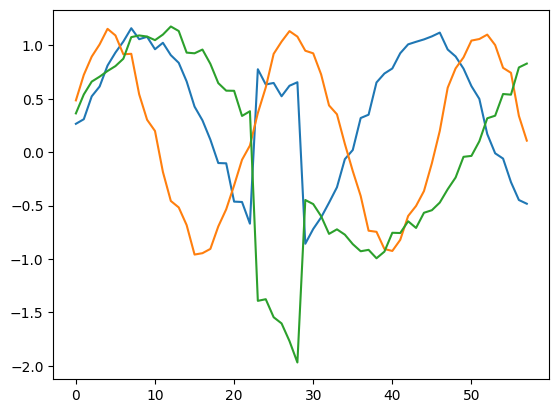

[False False False  True  True]


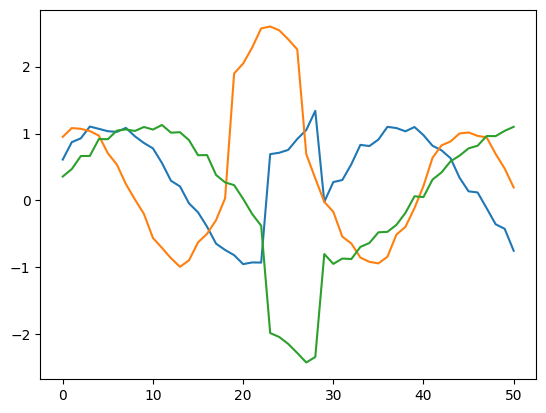

[False False False False False]


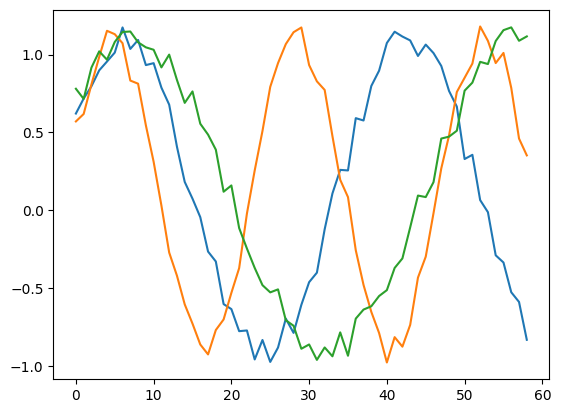

[ True False False False  True]


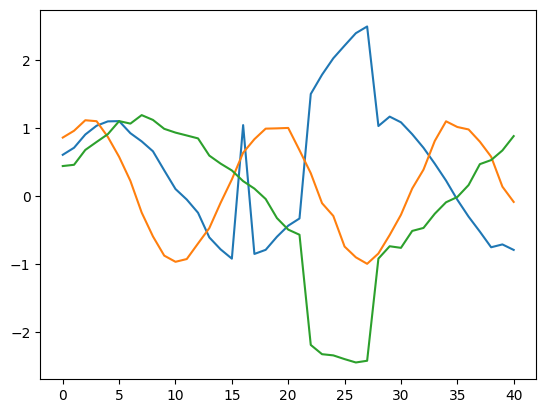

[False  True False False False]


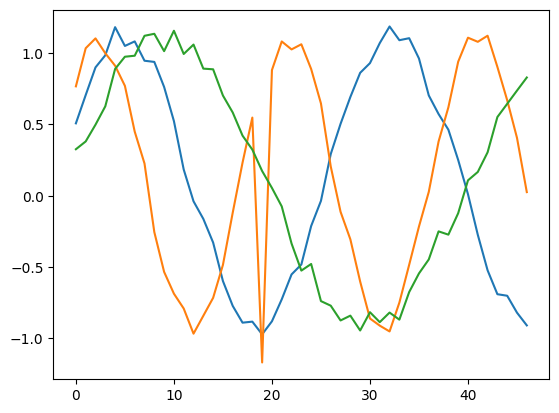

In [236]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

# Solution

In [7]:
print(xl[0])

[[ 0.26629699  0.48574277  0.36391429]
 [ 0.30934984  0.7245592   0.54140266]
 [ 0.52347576  0.8955255   0.66165987]
 [ 0.61586979  1.01015433  0.70790656]
 [ 0.81186389  1.15600173  0.7610961 ]
 [ 0.93386212  1.09415013  0.80695859]
 [ 1.03715876  0.91757752  0.87610299]
 [ 1.16171011  0.92201954  1.0782043 ]
 [ 1.05904494  0.54237835  1.09406918]
 [ 1.08143694  0.30428257  1.08365583]
 [ 0.96480948  0.19900708  1.05009377]
 [ 1.02530106 -0.18445725  1.10219756]
 [ 0.90935975 -0.45634367  1.17807806]
 [ 0.83749434 -0.51709525  1.13542961]
 [ 0.66336656 -0.68251854  0.93317632]
 [ 0.42746462 -0.95853197  0.9268377 ]
 [ 0.29846301 -0.9456677   0.96183929]
 [ 0.11770333 -0.90550167  0.82789007]
 [-0.10127261 -0.69509211  0.64752522]
 [-0.10388178 -0.53451348  0.57683276]
 [-0.46262855 -0.31065108  0.57547318]
 [-0.46604675 -0.07081758  0.33989122]
 [-0.66932554  0.06266696  0.38416678]
 [ 0.77741465  0.3674488  -1.39221771]
 [ 0.63495851  0.60680826 -1.37680454]
 [ 0.6489907   0.9214602 

In [8]:
for i in range(5):
    print(xl[i].shape)

(58, 3)
(51, 3)
(59, 3)
(41, 3)
(47, 3)


## Preprocessing
- padding
- train-test-validation split

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

padding_mask_value = 1000.0
xl_padded = pad_sequences(xl, dtype='float32', padding='post', value=padding_mask_value)
xl_padded_arr = np.array(xl_padded)
yl_arr = np.array(yl, dtype='bool')

# 80-10-10
xl_train, xl_temp, yl_train, yl_temp = train_test_split(xl_padded_arr, yl_arr, test_size=0.2, random_state=42)
xl_test, xl_val, yl_test, yl_val = train_test_split(xl_temp, yl_temp, test_size=0.5, random_state=42)

## Defects detection (classification) model

In [10]:
random_seed = 42

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Masking

# layers
model = Sequential()
model.add(Masking(mask_value=padding_mask_value, input_shape=xl_train[0].shape))
model.add(LSTM(128))
model.add(Dense(5, activation='sigmoid'))  # sigmoid because of binary output
model.summary()

# compile and train
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='acc'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
model.fit(
    xl_train, yl_train,
    validation_data=(xl_val, yl_val),
    epochs=100,
    callbacks=[early_stopping],
    batch_size=10,
    verbose=1
)

# eval
loss, accuracy = model.evaluate(xl_test, yl_test, verbose=2)
print(f'\tAccuracy: {accuracy}')
print(f'\tLoss: {loss}')

model.save('class-lstm128.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 68229 (266.52 KB)
Trainable params: 68229 (266.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4000/4000 [==============================] - 50s 12ms/step - loss: 0.3111 - acc: 0.4140 - val_loss: 0.2582 - val_acc: 0.4420
Epoch 2/100
4000/4000 [==============================] - 53s 13ms/step - loss: 0.1988 - acc: 0.4803 - val_loss: 0.1470 - val_acc: 0.5010
Epoch 3/

C:\Users\bujowskis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import keras
from keras.src.saving.saving_lib import load_model

random_seed = 42

model = load_model('class-lstm128.keras')

In [10]:
def convert_prediction(prediction: np.array):
    """
    Given real-valued output of the model, this converts it to True/False based on threshold
    """
    return np.where(prediction > 0.5, True, False)

In [14]:
# check predictions manually
for predicted, actual in zip(model.predict(xl_padded_arr[:3]), yl_arr[:3]):
    print(f'predicted:\t{convert_prediction(predicted)}')
    print(f'actual:\t\t{actual}')
    print('***')

1/1 [==============================] - 2s 2s/step
predicted:	[False False False False  True]
actual:		[False False False False  True]
***
predicted:	[False False False  True  True]
actual:		[False False False  True  True]
***
predicted:	[False False False False False]
actual:		[False False False False False]
***


In [15]:
test_predictions_converted = [convert_prediction(prediction) for prediction in model.predict(xl_test)]
accuracy_on_converted = np.mean(test_predictions_converted == yl_test)
print(f'Accuracy on converted: {accuracy_on_converted}')

157/157 [==============================] - 2s 15ms/step
Accuracy on converted: 0.99924


## Data parts corresponding to defects (autoencoder) model

In [96]:
@keras.saving.register_keras_serializable()
def custom_masked_loss(y_true, y_pred, mask_value=1000):
    # Create a binary mask where 1 indicates unmasked values and 0 indicates masked values
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    # Calculate mean squared error only on unmasked values
    return K.mean(K.square((y_true - y_pred) * mask), axis=-1)

In [ ]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RepeatVector, Masking, Dense, Bidirectional, Dropout, BatchNormalization
from keras import backend as K

random_seed = 42

# architecture
input_shape = xl_train[0].shape
padded_sequence_length = input_shape[0]
autoencoder = Sequential()
# encoding
autoencoder.add(Masking(mask_value=padding_mask_value, input_shape=xl_train[0].shape))
autoencoder.add(Bidirectional(LSTM(8, return_sequences=True)))
autoencoder.add(LSTM(8))
autoencoder.add(BatchNormalization())
# decoding
autoencoder.add(RepeatVector(padded_sequence_length))
autoencoder.add(Bidirectional(LSTM(8, return_sequences=True)))
autoencoder.add(Dropout(0.5))
autoencoder.add(Dense(input_shape[1], activation='linear'))
autoencoder.add(BatchNormalization())

autoencoder.compile(
    optimizer='adam',
    loss=custom_masked_loss,
    metrics=['mean_squared_error', 'mean_absolute_error']
)
autoencoder.summary()

# training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
autoencoder.fit(
    xl_train, xl_train,
    epochs=100,
    batch_size=5,
    callbacks=early_stopping,
    shuffle=True,
    validation_data=(xl_val, xl_val)
)

autoencoder.save('autoencoder-custom-loss-batch-normalization-8-8-8-drop05-batch5.keras')

In [90]:
import matplotlib.pyplot as plt

# Assuming xl_test and autoencoder_predictions are NumPy arrays
# with sequences to be plotted

def plot_comparison(sample_index, predictions):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot original sequence
    xl_test_to_plot = xl_test[sample_index][:30]
    axes[0].plot(xl_test_to_plot)
    axes[0].set_title('Original')
    
    # Plot autoencoder prediction
    autoencoder_prediction_to_plot = predictions[sample_index][:30]
    axes[1].plot(autoencoder_prediction_to_plot)
    axes[1].set_title('Autoencoder Prediction')

    # Set y-axis limits to be the same for both subplots
    y_min = min(xl_test_to_plot.min(), autoencoder_prediction_to_plot.min())
    y_max = max(xl_test_to_plot.max(), autoencoder_prediction_to_plot.max())

    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)

    # Add labels, title, etc., as needed
    plt.tight_layout()
    plt.show()
    print(f'Defects in xl_test[{sample_index}]: {yl_test[sample_index]}')

In [157]:
autoencoder = load_model('autoencoder-custom-loss-batch-normalization-8-8-8-drop05-batch5.keras')
autoencoder_predictions = autoencoder.predict(xl_test)

157/157 [==============================] - 5s 12ms/step


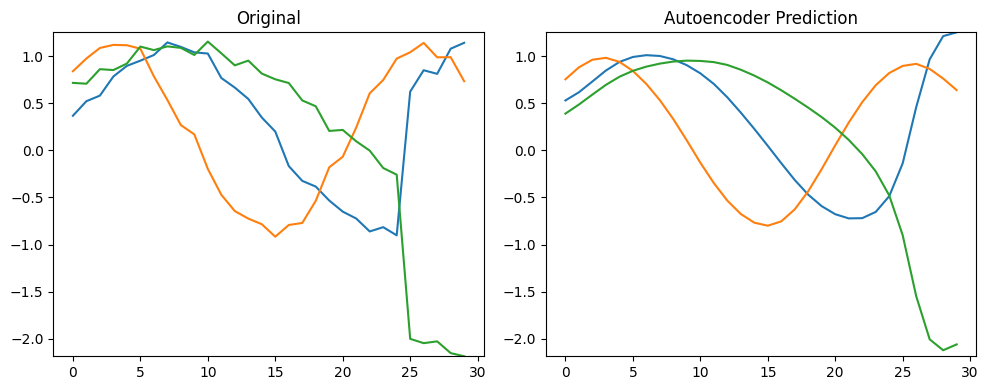

Defects in xl_test[0]: [False False False  True  True]


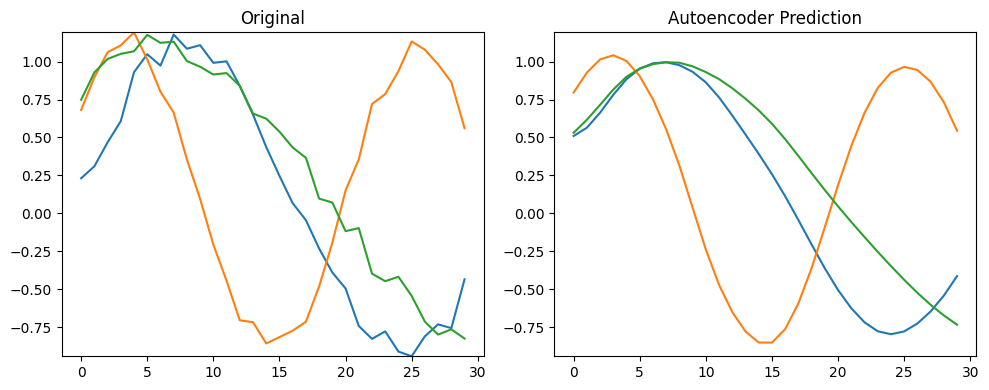

Defects in xl_test[1]: [False False False False False]


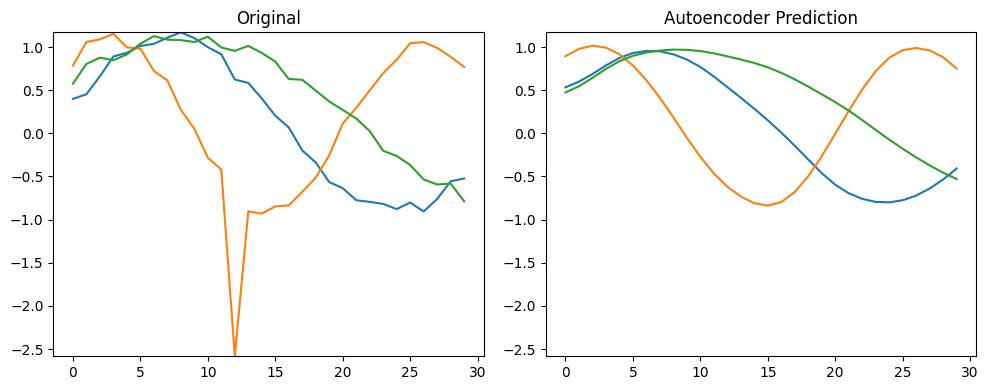

Defects in xl_test[2]: [False  True  True False False]


In [156]:
for i in range(0, 3):
    plot_comparison(i, autoencoder_predictions)

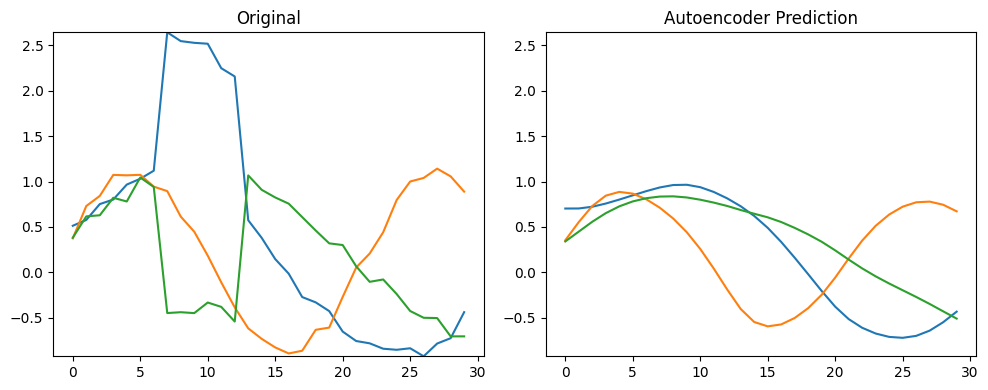

Defects in xl_test[100]: [False False False False  True]


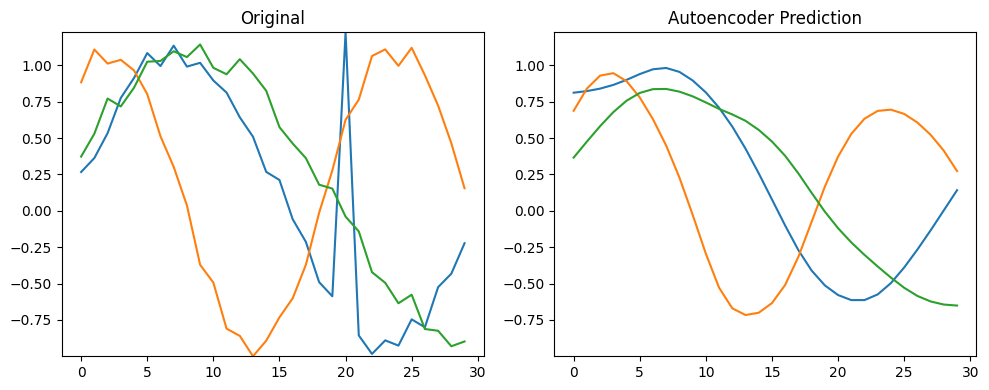

Defects in xl_test[101]: [ True False False  True False]


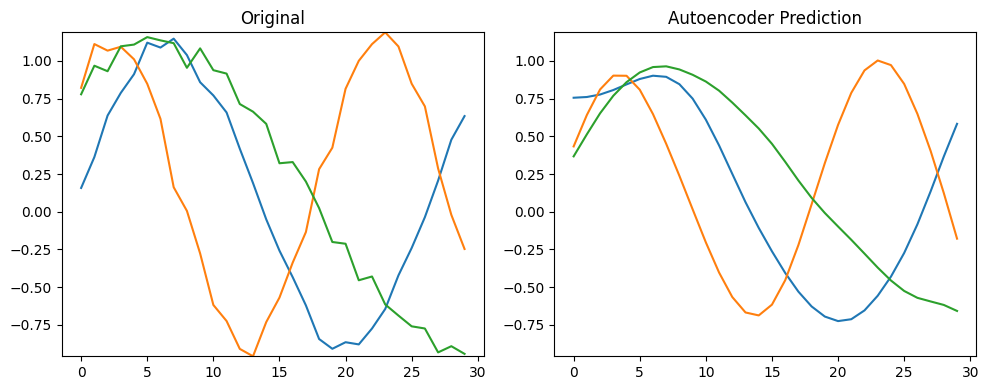

Defects in xl_test[102]: [False  True False False False]


In [154]:
for i in range(100, 103):
    plot_comparison(i, autoencoder_predictions)

In [200]:
class AutoencoderPredictor:
    def __init__(self, autoencoder_model: Sequential):
        self.autoencoder = autoencoder_model
    
    def get_prediction_without_padding_for(self, xl_in):
        """
        Calculates autoencoder prediction for proper xl_in without defects.\n
        Handles both padded and non-padded input sequences.
        :param xl_in: input sequence to calculate prediction for
        :return: tuple of non-padded sequences (xl_in, prediction)
        """
        # add padding if needed
        xl_in_padded = pad_sequences([xl_in], dtype='float32', padding='post', value=padding_mask_value)#[0]
        # predict
        prediction = self.autoencoder.predict(xl_in_padded)[0]
        xl_in_padded = xl_in_padded[0]
        # trim padding if needed
        padding_indices = np.where(np.all(xl_in_padded == padding_mask_value, axis=1))
        without_padding_idx = padding_indices[0][0] if len(padding_indices) > 0 else len(xl_in_padded)
        prediction_trimmed = prediction[:without_padding_idx]
        xl_in_trimmed = xl_in_padded[:without_padding_idx]
        return xl_in_trimmed, prediction_trimmed

## Solution - CandyDefectAnalyzer

In [230]:
class CandyDefectAnalyzer:
    def __init__(self, classifier: Sequential,
                 autoencoder_predictor: AutoencoderPredictor,
                 defects_indices_sensitivity: float = 0.5,  # note - could be relative instead of absolute
                 defects_should_skip_initial: int = 5):
        """
        Analyzer for defects in candy sensors data.\n
        Performs analysis based on provided models and parameter configs
        :param classifier: model classifying identified defects
        :param autoencoder_predictor: model predicting "ideal world" data expected from sensors
        :param defects_indices_sensitivity: acceptable absolute difference between "ideal world" and actual sensors data (used to determine parts of data likely corresponding to the defects); 0.3 by default
        :param defects_should_skip_initial: how many first indices should be excluded from defects indices (used to workaround possible issue of `autoencoder_predictor` getting first indices of "ideal world" prediction wrong)
        """
        self.classifier = classifier
        self.autoencoder_predictor = autoencoder_predictor
        self.defects_indices_sensitivity = defects_indices_sensitivity
        self.initial_indices_to_skip_in_defects_root_cause = np.array([i for i in range(defects_should_skip_initial)])
    
    def analyze(self, xl_in, should_plot_results: bool = False):
        """
        Analyzes the provided sequence of candy sensors data.\n
        For the respective batch of candy it provides:\n
        - prediction for the likely defects
        - prediction for the likely "ideal world" data expected from sensors
        - parts of sequence that likely correspond with the defects
        :param xl_in: input sequence to analyze
        :param should_plot_results: if the results should be plotted; `False` by default
        :return: tuple of (defects_prediction, ideal_sequence_prediction, indices_corresponding_defects)
        """
        xl_in_padded = pad_sequences([xl_in], dtype='float32', padding='post', value=padding_mask_value)
        defects_prediction = convert_prediction(self.classifier.predict(xl_in_padded)[0])
        auto_xl_in, auto_prediction = self.autoencoder_predictor.get_prediction_without_padding_for(xl_in)
        
        auto_prediction_difference_bigger_than_threshold = np.any(
            np.abs(auto_xl_in - auto_prediction) > self.defects_indices_sensitivity, axis=1)
        diff_bigger_indices = np.where(auto_prediction_difference_bigger_than_threshold)[0]
        diff_bigger_indices_removed_initial = np.setdiff1d(diff_bigger_indices, self.initial_indices_to_skip_in_defects_root_cause)
        
        if should_plot_results:
            print(f'Predicted defects: {defects_prediction}')
            print('Plots of actual and Ideal sensors readings\n(parts likely corresponding with the defects highlighted red)')
            # Create subplots
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            # Plot original sequence
            axes[0].plot(auto_xl_in)
            axes[0].set_title('Actual')
    
            # Plot autoencoder prediction
            axes[1].plot(auto_prediction)
            axes[1].set_title('Ideal')

            # Highlight areas based on filtered_indices
            for idx in diff_bigger_indices_removed_initial:
                axes[0].axvspan(idx - 0.5, idx + 0.5, color='red', alpha=0.3)

            # Set y-axis limits to be the same for both subplots
            y_min = min(auto_xl_in.min(), auto_prediction.min())
            y_max = max(auto_xl_in.max(), auto_prediction.max())
            axes[0].set_ylim(y_min, y_max)
            axes[1].set_ylim(y_min, y_max)

            # Add labels, title, etc., as needed
            plt.tight_layout()
            plt.show()
        
        return defects_prediction, auto_prediction, diff_bigger_indices_removed_initial

In [237]:
classifier_model = load_model('class-lstm128.keras')
# for autoencoder, seemingly similar performance for batch 10 and 5
# - batch 10 sometimes has unnecessary problems at end of sequences
# - batch 5 sometimes preserves signals indicating defects (often not good enough not to trigger threshold though)
autoencoder_model = load_model('autoencoder-custom-loss-batch-normalization-8-8-8-drop05-batch10.keras')
# autoencoder_model = load_model('autoencoder-custom-loss-batch-normalization-8-8-8-drop05-batch5.keras')

1/1 [==============================] - 2s 2s/step
Predicted defects: [False False False  True  True]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


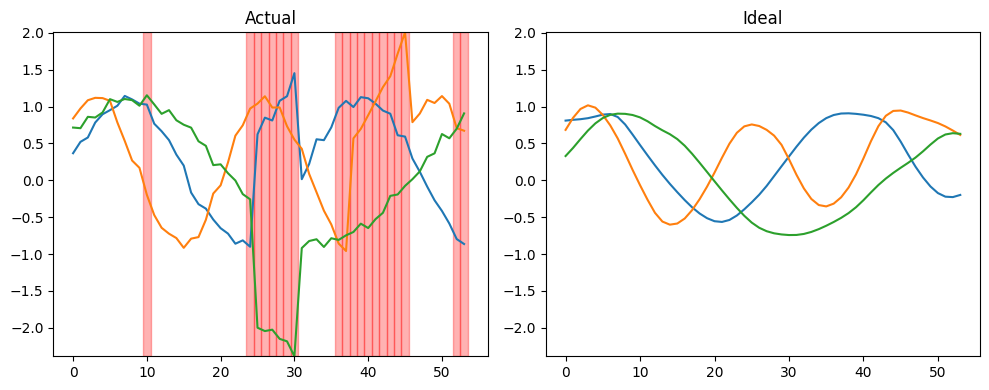

In [238]:
candy_defect_analyzer = CandyDefectAnalyzer(classifier_model, AutoencoderPredictor(autoencoder_model))
foo = candy_defect_analyzer.analyze(xl_test[0], should_plot_results=True)

------
(actual defects: [False False False  True  True])

1/1 [==============================] - 0s 22ms/step
Predicted defects: [False False False  True  True]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


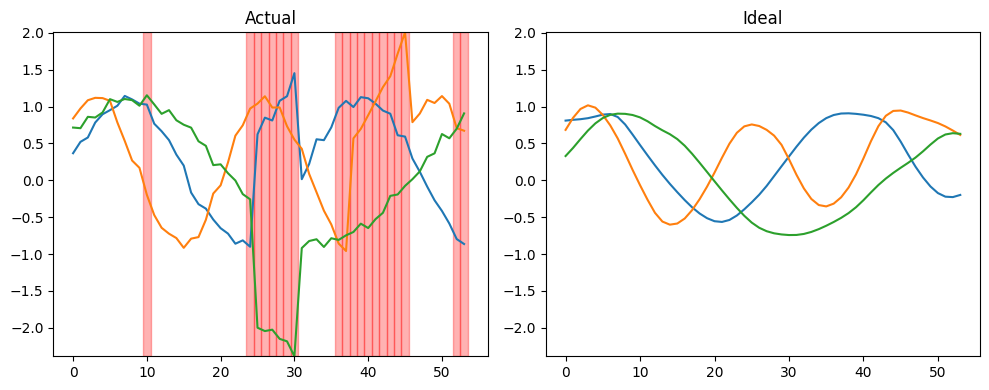

------
------
(actual defects: [False False False False False])

1/1 [==============================] - 0s 21ms/step
Predicted defects: [False False False False False]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


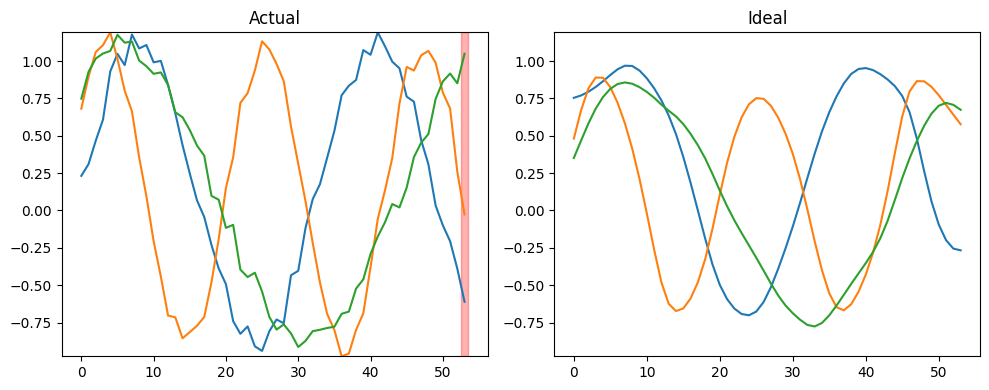

------
------
(actual defects: [False  True  True False False])

1/1 [==============================] - 0s 20ms/step
Predicted defects: [False  True  True False False]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


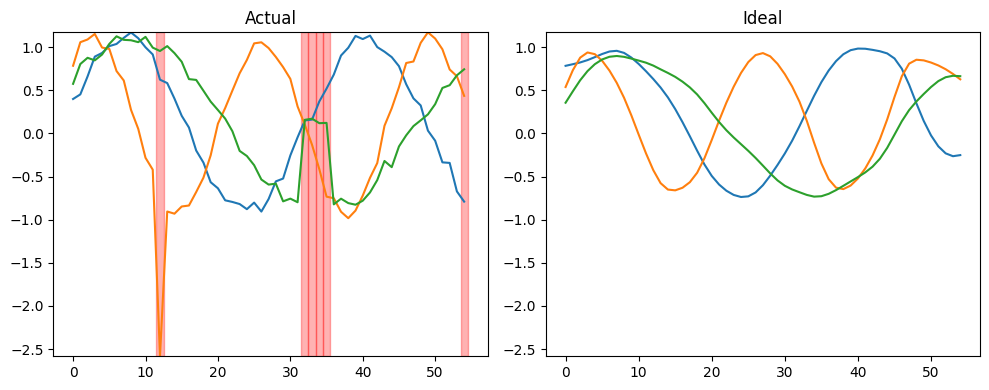

------
------
(actual defects: [False False False False  True])

1/1 [==============================] - 0s 21ms/step
Predicted defects: [False False False False  True]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


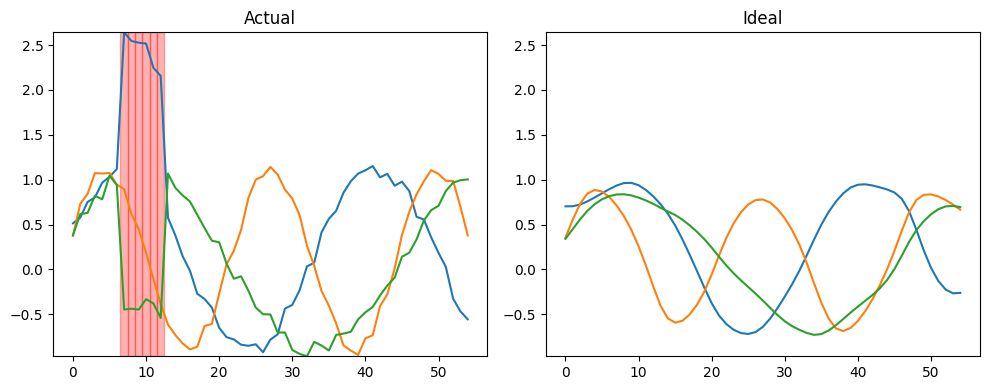

------
------
(actual defects: [ True False False  True False])

1/1 [==============================] - 0s 19ms/step
Predicted defects: [ True False False  True False]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


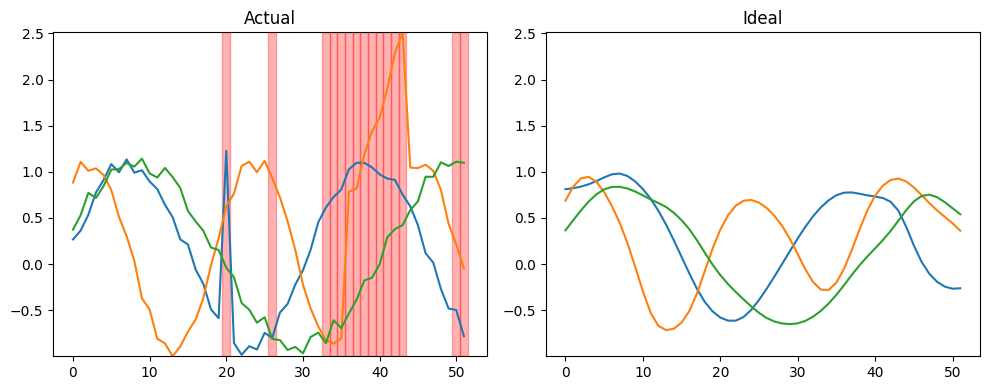

------
------
(actual defects: [False  True False False False])

1/1 [==============================] - 0s 20ms/step
Predicted defects: [False  True False False False]
Plots of actual and Ideal sensors readings
(parts likely corresponding with the defects highlighted red)


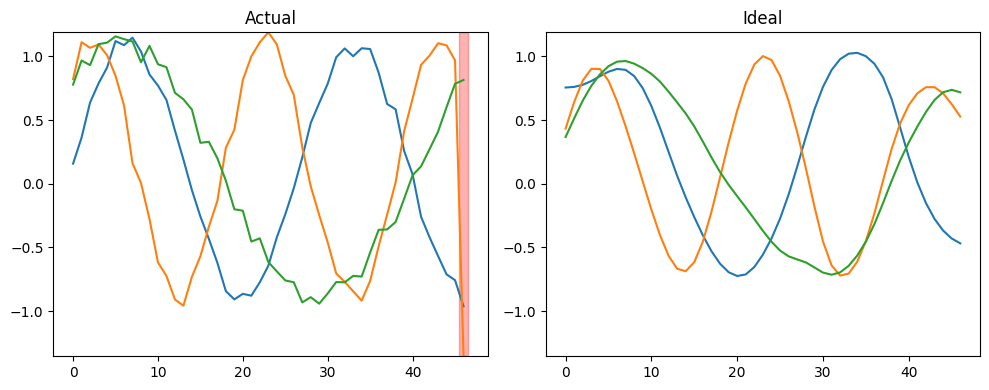

------


In [239]:
for i in [0, 1, 2, 100, 101, 102]:
    print('------')
    print(f'(actual defects: {yl_test[i]})\n')
    foo = candy_defect_analyzer.analyze(xl_test[i], should_plot_results=True)
    print('------')

In [ ]:
# [x] todo - screenshots of comparison how models compare
# [x] todo - compare screenshots of batch 5 and 10, use better
# 10 - 5
#  4 - 2
# [ ] todo - compress trained unused models
# [ ] todo - cut out unused code
# [ ] todo - comment explanations on code used in the end
# [ ] todo - report "how we got there"? (can do directly in this notebook?) - including photos